In [1]:
import sys
sys.path.append('../src')

import albumentations as A
import random
import numpy as np
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation, OneFormerConfig
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
from transformers.models.oneformer.image_processing_oneformer import load_metadata, prepare_metadata
from safetensors.torch import load_model, save_model
from config import DATASET_DIR, CLASS_INFO_PATH, MAIN_PROJECT_DIR, GALAXY_MEAN, GALAXY_STD
from visual import *
from dataset import *
from utils import *

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.16 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [2]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
id2label, label2id = get_id2label_mappings()

config = OneFormerConfig.from_pretrained("shi-labs/oneformer_ade20k_swin_tiny", 
                                         num_classes = len(id2label),
                                         id2label = id2label,
                                         label2id = label2id,
                                         is_training=True)

/home/panzaresce/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
# model_card = "shi-labs/oneformer_coco_dinat_large"
model_card = "shi-labs/oneformer_ade20k_swin_tiny"
model = OneFormerForUniversalSegmentation.from_pretrained(model_card, config=config, ignore_mismatched_sizes=True)
processor = OneFormerProcessor.from_pretrained(model_card)

Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

In [6]:
# Metadata must be set according to the dataset through the class_info.json file. Background class must be specified as well. 
processor.image_processor.repo_path = MAIN_PROJECT_DIR
processor.image_processor.class_info_file = os.path.join(MAIN_PROJECT_DIR, CLASS_INFO_PATH)
processor.image_processor.metadata = prepare_metadata(load_metadata(MAIN_PROJECT_DIR, os.path.join(MAIN_PROJECT_DIR, CLASS_INFO_PATH)))
processor.image_processor.num_text = model.config.num_queries - model.config.text_encoder_n_ctx
processor.image_processor.do_resize = False
processor.image_processor.do_rescale = False

In [7]:
# Augmentations
transform = A.Compose([
    A.OneOf([
        A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.OneOf([
                A.Rotate(limit=(90), p=1),
                A.Rotate(limit=(180), p=1),
                A.Rotate(limit=(270), p=1)
            ], p=1)
        ]),
        A.NoOp()
    ], p=1.0)
])

In [8]:
dataset_abl = GalaxyDataset(DATASET_DIR, "test", processor, CLASS_INFO_PATH, None, GALAXY_MEAN, GALAXY_STD, load_on_demand=True, subset_idx=1000)
dataset_abl_trans = GalaxyDataset(DATASET_DIR, "test", processor, CLASS_INFO_PATH, transform, GALAXY_MEAN, GALAXY_STD, load_on_demand=True, subset_idx=1000)

In [9]:
def train_for_grid_search(dataset, dict_value, grad_clip = False):
    model = OneFormerForUniversalSegmentation.from_pretrained(model_card, config=config, ignore_mismatched_sizes=True)
    
    optimizer = AdamW(model.parameters(), lr=dict_value["param"]["lr"], weight_decay=dict_value["param"]["wd"])
    model.to(device)
    
    scheduler_list = list()

    if dict_value["param"]["lr_d"] == "poly":
        scheduler_list.append(WarmupPolyLR(optimizer, len(dataset), warmup_iters=0, warmup_factor=0.01))
    if dict_value["param"]["lr_d"] == "warm":
        scheduler_list.append(WarmupPolyLR(optimizer, len(dataset), warmup_iters=10, warmup_factor=0.01))
    if dict_value["param"]["lr_d"] == "fixed":
        scheduler_list.append(torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[900,950], gamma=0.1))
    if dict_value["param"]["lr_d"] == "warm_fixed":
        scheduler_list.append(WarmupPolyLR(optimizer, len(dataset), warmup_iters=10, warmup_factor=0.01))
        scheduler_list.append(torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[900,950], gamma=0.1))

    overfit_loader = DataLoader(dataset, batch_size=1, shuffle=False)

    print("Training")
    training_mode(model)
    for batch_idx, batch in enumerate(overfit_loader):
        # plt.imshow(batch["pixel_values"].squeeze().permute(1,2,0))
        optimizer.zero_grad()

        batch = {k:v.to(device) for k,v in batch.items()}
        outputs = model(**batch)  
        
        dict_value["loss"].append(outputs.loss.item())

        outputs.loss.backward()
        if grad_clip:
            clip_grad_norm_(model.parameters(), dict_value["param"]["clip"])
        optimizer.step()

        if dict_value["param"]["lr_d"] != None:
            for sched in scheduler_list:
                sched.step()
    
    print("Evaluation")
    miou, dice = compute_metrics(dataset, model, processor)
    dict_value["miou"] = miou/len(dataset)
    dict_value["dice"] = dice/len(dataset)

In [10]:
def visualize_grid_search_results(grid_dict):
    for k,v in grid_dict.items():
        plt.plot(v["loss"], label=v["param"])
        plt.legend()
        val = {a: b for a,b in v.items() if a != "loss" }
        print(f"{k}: {val}")

First round of grid search, the following hyperparameters are tested:
- learning rate: [1e-3, 1e-4]
- weight decay: [0.01, 0.05, 0.1]
- scheduler: [None, polynomial, warmup+poly, decay fixed, warmup+decay fixed]
    - The "decay fixed" reduce the lr by a factor of 10 at 90% and 95% of total steps

In [11]:
grid_dict = {
    0: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.01,
            "lr_d": None
        }
    },
    1: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": None
        }
    },
    2: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-3,
            "wd": 0.05,
            "lr_d": None
        }
    },
    3: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": None
        }
    },
    4: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "poly"
        }
    },
    5: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "poly"
        }
    },
    6: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "fixed"
        }
    },
    7: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "fixed"
        }
    },
    8: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "warm"
        }
    },
    9: {
        "loss": list(),
        "miou": 0,
        "acc": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "warm"
        }
    },
    10: {
        "loss": list(),
        "miou": 0,
        "acc": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "warm_fixed"
        }
    },
    11: {
        "loss": list(),
        "miou": 0,
        "acc": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "warm_fixed"
        }
    }
}

In [12]:
for k,v in grid_dict.items():
    print(f"Processing conf n. {k}")
    train_for_grid_search(dataset_abl, v)

Processing conf n. 0


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training


/home/panzaresce/anaconda3/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Evaluation
Processing conf n. 1


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 2


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 3


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 4


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 5


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 6


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 7


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 8


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 9


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 10


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 11


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation


0: {'miou': tensor(0.3694), 'dice': tensor(0.3997), 'param': {'lr': 0.0001, 'wd': 0.01, 'lr_d': None}}
1: {'miou': tensor(0.3620), 'dice': tensor(0.3933), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': None}}
2: {'miou': tensor(0.3540), 'dice': tensor(0.3893), 'param': {'lr': 0.001, 'wd': 0.05, 'lr_d': None}}
3: {'miou': tensor(0.1832), 'dice': tensor(0.1990), 'param': {'lr': 0.0001, 'wd': 0.1, 'lr_d': None}}
4: {'miou': tensor(0.3989), 'dice': tensor(0.4280), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'poly'}}
5: {'miou': tensor(0.3842), 'dice': tensor(0.4100), 'param': {'lr': 0.0001, 'wd': 0.1, 'lr_d': 'poly'}}
6: {'miou': tensor(0.3852), 'dice': tensor(0.4132), 'param': {'lr': 0.0001, 'wd': 0.1, 'lr_d': 'fixed'}}
7: {'miou': tensor(0.3932), 'dice': tensor(0.4222), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'fixed'}}
8: {'miou': tensor(0.4085), 'dice': tensor(0.4370), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'warm'}}
9: {'miou': tensor(0.4306), 'acc': 0, 'param': {'lr': 0.0001, 'wd

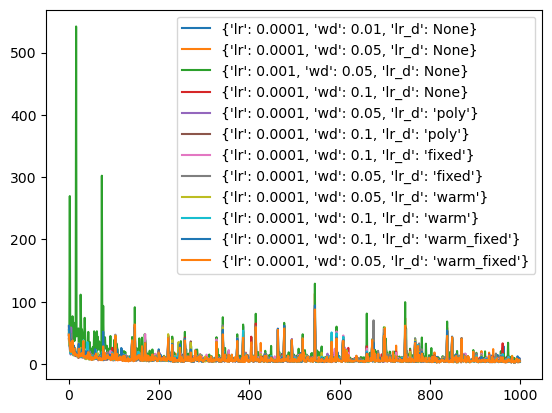

In [13]:
visualize_grid_search_results(grid_dict)

Second round of grid search, trying augmentation and gradient clipping on best configurations from step 1

In [14]:
# 4,7,9,11 from previous step
grid_dict_2 =  {
    0: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "poly",
            "clip": 1.0,
        }
    },
    1: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "fixed",
            "clip": 1.0,
        }
    },
    2: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "warm",
            "clip": 1.0,
        }
    },
    3: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "warm_fixed",
            "clip": 1.0,
        }
    },
    4: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "poly",
            "clip": 0.01,
        }
    },
    5: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "fixed",
            "clip": 0.01,
        }
    },
    6: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "warm",
            "clip": 0.01,
        }
    },
    7: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "warm_fixed",
            "clip": 0.01,
        }
    }
}

In [15]:
for k,v in grid_dict_2.items():
    print(f"Processing conf n. {k}")
    train_for_grid_search(dataset_abl, v, True)

Processing conf n. 0


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 1


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 2


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 3


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 4


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 5


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 6


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 7


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation


0: {'miou': tensor(0.4326), 'dice': tensor(0.4619), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'poly', 'clip': 1.0}}
1: {'miou': tensor(0.3812), 'dice': tensor(0.4070), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'fixed', 'clip': 1.0}}
2: {'miou': tensor(0.4307), 'acc': 0, 'param': {'lr': 0.0001, 'wd': 0.1, 'lr_d': 'warm', 'clip': 1.0}, 'dice': tensor(0.4606)}
3: {'miou': tensor(0.4254), 'acc': 0, 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'warm_fixed', 'clip': 1.0}, 'dice': tensor(0.4565)}
4: {'miou': tensor(0.4242), 'dice': tensor(0.4532), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'poly', 'clip': 0.01}}
5: {'miou': tensor(0.4228), 'dice': tensor(0.4628), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'fixed', 'clip': 0.01}}
6: {'miou': tensor(0.4276), 'acc': 0, 'param': {'lr': 0.0001, 'wd': 0.1, 'lr_d': 'warm', 'clip': 0.01}, 'dice': tensor(0.4600)}
7: {'miou': tensor(0.4326), 'acc': 0, 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'warm_fixed', 'clip': 0.01}, 'dice': tensor(0.4630)}


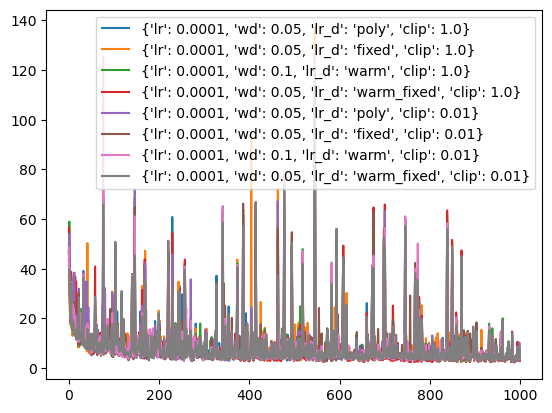

In [16]:
visualize_grid_search_results(grid_dict_2)

Third round of grid search, add augmentation

In [11]:
# 0,2,6,7 from previous step
grid_dict_3 =  {
    0: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "poly",
            "clip": 1.0,
        }
    },
    1: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "warm",
            "clip": 1.0,
        }
    },
    2: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "warm",
            "clip": 0.01,
        }
    },
    3: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "warm_fixed",
            "clip": 0.01,
        }
    },
    4: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "poly",
            "clip": 0.1,
        }
    },
    5: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "warm",
            "clip": 0.1,
        }
    },
    6: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "warm_fixed",
            "clip": 0.1,
        }
    }
}

In [12]:
for k,v in grid_dict_3.items():
    print(f"Processing conf n. {k}")
    train_for_grid_search(dataset_abl_trans, v, True)

Processing conf n. 0


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training


/home/panzaresce/anaconda3/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Evaluation
Processing conf n. 1


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 2


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 3


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation


0: {'miou': tensor(0.4077), 'dice': tensor(0.4368), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'poly', 'clip': 1.0}}
1: {'miou': tensor(0.4269), 'dice': tensor(0.4587), 'param': {'lr': 0.0001, 'wd': 0.1, 'lr_d': 'warm', 'clip': 1.0}}
2: {'miou': tensor(0.4134), 'dice': tensor(0.4440), 'param': {'lr': 0.0001, 'wd': 0.1, 'lr_d': 'warm', 'clip': 0.01}}
3: {'miou': tensor(0.4002), 'dice': tensor(0.4295), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'warm_fixed', 'clip': 0.01}}
4: {'miou': tensor(0.3938), 'dice': tensor(0.4264), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'poly', 'clip': 0.1}}
5: {'miou': tensor(0.4164), 'dice': tensor(0.4466), 'param': {'lr': 0.0001, 'wd': 0.1, 'lr_d': 'warm', 'clip': 0.1}}
6: {'miou': tensor(0.3839), 'dice': tensor(0.4119), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'warm_fixed', 'clip': 0.1}}


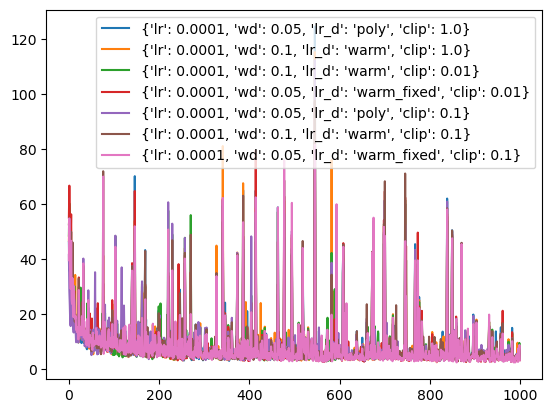

In [21]:
visualize_grid_search_results(grid_dict_3)